In [109]:

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64

### vgg feature analysis 

In [110]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from glob import glob
import os

import embedding_labelconcept as emb
reload(emb)
from embedding_labelconcept import *

In [111]:
# retrieve sketch paths
def list_files(path, ext='jpg'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
path_to_images = '/home/bria/labelconcept/allImages'
image_paths = sorted(list_files(path_to_images))

In [112]:
## number of images
print 'Number of image paths = {}'.format(len(image_paths))

Number of image paths = 221


## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult'`

In [113]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.category.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features(layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']            
    F = np.load('/home/bria/labelconcept/python/features/FEATURES_{}.npy'.format(layers[layer_num]))
    M = pd.read_csv('/home/bria/labelconcept/python/features/METADATA.csv') 
    return F, M


def get_and_plot_RDM(M,F):
    labels = M.category.values
    labelsPlot = np.unique(M.category.values) ## CHECK THAT THIS IS RIGHT?
    means = get_class_means(F, labels)
    sns.set_style('white')
    CORRMAT = np.corrcoef(means)
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    RDM = 1-CORRMAT
    plt.matshow(RDM, vmin=0, vmax=2)
    plt.xticks(range(len(labelsPlot)), labelsPlot, rotation=90);
    plt.yticks(range(len(labelsPlot)), labelsPlot); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    plt.gcf().subplots_adjust(left=0.5) 
#     plt.tight_layout()    
#     plt.savefig('./plots/RDM_{}.pdf'.format(cohort))
    return RDM

def get_RDM(M,F,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]    
    RDM = np.corrcoef(ordered_means)
    return RDM

In [114]:
## Load in image features for a given layer
F, M = load_features(6)
M = M.reset_index(drop=True)

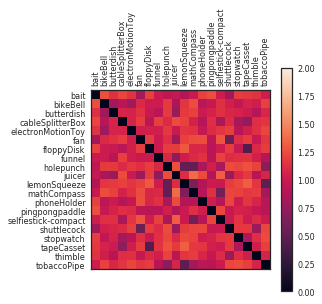

In [115]:
## Plot RDM
RDM = get_and_plot_RDM(M,F)


In [105]:
ref_category_name = 'bikeBell'
labelsPlot = np.unique(M.category.values) # unique categories
labelsPlot = np.asarray(labelsPlot)
arr_index = np.where(labelsPlot == ref_category_name)
ref_category = arr_index[0]
ref_category

array([0])

array([ 1.26024289,  1.12863737,  1.22318816,  1.14747611,  0.81601622,
        1.20570932,  1.00109697,  0.94727423,  0.98043338,  0.88347222,
        0.9957858 ,  1.20897739,  1.26182475,  1.01778785,  0.80221622,
        1.19343668,  1.16759054,  1.14176639,  1.01681557,  0.79822712,
        0.9130442 ,  0.79664303,  1.09891434,  1.01259543,  1.0083243 ,
        1.17282049,  0.84757995,  1.15207616,  1.25777271,  0.92212387,
        0.98014324,  1.13134402,  1.04544116,  0.95886646,  1.05962612,
        1.02550757,  1.20432511,  1.06460317,  1.05655295,  1.13570929,
        0.99146172,  0.91870406,  1.17689029,  0.76013064,  1.17741604,
        1.20912467,  1.00632203,  1.05849477,  1.1261453 ,  1.07304234,
        1.05825723,  1.01272092,  0.89940432,  1.08568989,  1.05757104,
        1.18541253,  0.92274946,  1.19858722,  1.103651  ,  1.24233334,
        1.20819715,  1.04789177,  0.89501218,  1.1204343 ,  0.85096762,
        1.10753474,  0.82845931,  0.73351023,  1.12431408,  1.15

array([0])

In [106]:

dissimValues = RDM[ref_category,:]

## check ref category index + 1 dissimilarity is always 0 (or 1, depending on dissim vs. sim)
RDM[ref_category+1,ref_category+1]

## get dissim values for this set
dissimValues = RDM[ref_category,:]

In [107]:
## get some dissimilarity values relative to a given reference category index
dissimValues = RDM[ref_category,:]
dissimValues = np.delete(dissimValues,ref_category) # delete the identity values
labelsPlot = np.delete(labelsPlot,ref_category) # delete the identity category (ref category)

## sort by dissimilarity
ind =  np.argsort(dissimValues)
dissimValues = dissimValues[ind]
labelsPlot = labelsPlot [ind]

([<matplotlib.axis.XTick at 0x7f459b26bd90>,
 <a list of 3 Text xticklabel objects>)

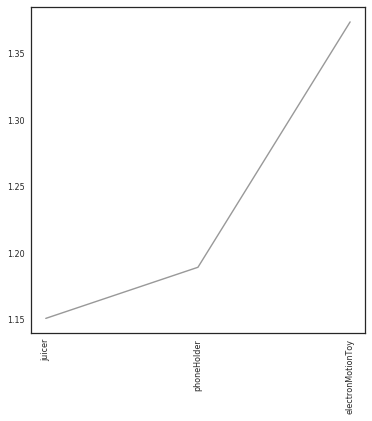

In [108]:
## plot these values
plt.figure(figsize=(6,6))
plt.plot(np.arange(0,3),dissimValues, label='dissim values',color=(0.6,0.6,0.6))
plt.xticks(np.arange(0,3), labelsPlot, rotation='vertical')

array([ 1.27471035,  1.3947001 ,  0.        ,  1.11276242])

In [109]:
### Correlations between features in FC7 each class (e.g., object category)

In [76]:
# make general function
# def corr_cohort_classes(cohort1,cohort2,uniqueLabels):
#     if  np.shape(cohort1)==np.shape(cohort2): ## make sure same shape
#         classCor=np.zeros(np.shape(uniqueLabels)[0]) # open variable
#         for vi, v in enumerate(np.asarray(uniqueLabels)):
#             cohort1Vec = cohort1[uniqueLabels == v,:]
#             cohort2Vec = cohort2[uniqueLabels == v,:]
#             cohort1Vec=np.reshape(cohort1Vec,np.shape(cohort1Vec)[1],np.shape(cohort1Vec)[0]) # resahpe for corr
#             cohort2Vec=np.reshape(cohort2Vec,np.shape(cohort2Vec)[1],np.shape(cohort2Vec)[0])# resahpe for corr
#             classCor[vi]=stats.pearsonr(cohort1Vec,cohort2Vec)[0]
#         return classCor
    
# uniqueLabels=np.unique(KM.label.values)
# means_adult = get_class_means(AF, AM.label.values)
# means_kid = get_class_means(KF, KM.label.values)
# classCor=corr_cohort_classes(means_adult,means_kid,np.unique(KM.label.values))
# sortInd=np.argsort(classCor)
# print uniqueLabels[sortInd]
# print classCor[sortInd]

## print fc7 cross-cohort correlations

# dim = KRDM.shape[0]
# cor = stats.spearmanr(np.ravel(KRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
# print 'Correlation between adult and overall kid RDM: {}'.format(cor)

##### generate and save out RDMs as separate npy files

In [ ]:
# ## subsampling on or off?
# subsample_on = 1

# ## load in adult features
# really_run = 1
# if really_run:
#     for layer_num in np.arange(7):
#         print 'Loading in adult features for layer {}...'.format(layer_num)
#         AF, AM = load_features('adult',layer_num)
#         AF, AM = remove_practice_trials(AF, AM)
#         AM = AM.reset_index(drop=True)
#         AF, AM = adult_preproc(AF, AM, these_labels)
#         ## subsample features especially for lower layers
#         if subsample_on:
#             num_features = AF.shape[1]
#             size_subsample = 100000
#             if num_features>size_subsample:
#                 feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
#                 AF = AF[:,feat_inds]         
        
#         print 'Shape of adult feature tensor: {}'.format(np.shape(AF))

#         ## get RDM
#         cohort = 'adult'
#         print 'Getting and saving RDM...'
#         RDM = get_RDM(AM, AF,sort_inds)
#         ## save out RDM as npy
#         np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),ARDM)
        
#     print 'All done!'

Loading in adult features for layer 0...


In [ ]:
# ## subsampling on or off?
# subsample_on = 1

# really_run = 1
# lb = 0
# ub = 7
# if really_run:
#     ## loop through all kid layers and save out their RDM
#     for layer_num in np.arange(lb,ub):
#         ## load in kid features
#         KF, KM = load_features('kid',layer_num)
#         KF, KM = remove_practice_trials(KF, KM)
#         KM = KM.reset_index(drop=True)
#         KF, KM = preproc_kid(KF, KM, these_labels)
#         print 'Shape of kid feature tensor: {}'.format(np.shape(KF))
#         ## subsample features especially for lower layers
#         if subsample_on:        
#             num_features = KF.shape[1]
#             size_subsample = 100000
#             if num_features>size_subsample:
#                 feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
#                 KF = KF[:,feat_inds]           
        
#         ## get RDM
#         print 'Getting and saving RDM...'
#         cohort = 'kid'
#         KRDM = get_RDM(KM, KF,sort_inds)
#         ## save out RDM as npy
#         np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),KRDM)
        
#         print 'Saved OVERALL KID RDMs for layer {}!'.format(layer_num)        
                
#     ## loop through all kid layers and save out their RDM
#     for layer_num in np.arange(lb,ub):
#         ## load in kid features
#         KF, KM = load_features('kid',layer_num)
#         KF, KM = remove_practice_trials(KF, KM)
#         KM = KM.reset_index(drop=True)
#         KF, KM = preproc_kid(KF, KM, these_labels)
#         ## subsample features especially for lower layers
#         if subsample_on:
#             num_features = KF.shape[1]
#             size_subsample = 100000
#             if num_features>size_subsample:
#                 feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
#                 KF = KF[:,feat_inds]              
        
#         ## get RDM for older kids (7,8,9,10)
#         ind = KM.index[KM['coarse_age'] == 'older']
#         meta = KM.loc[ind]
#         feat = KF[ind.tolist()]
#         print 'Shape of older kid feature tensor: {}'.format(np.shape(feat))        
#         ORDM = get_RDM(meta, feat,sort_inds)
#         np.save('./rdm/RDM_{}_{}.npy'.format('older',layer_num),ORDM)            
#         print 'Saved OLDER KID RDMs for layer {}!'.format(layer_num)        
            
#     for layer_num in np.arange(lb,ub):
#         ## load in kid features
#         KF, KM = load_features('kid',layer_num)
#         KF, KM = remove_practice_trials(KF, KM)
#         KM = KM.reset_index(drop=True)
#         KF, KM = preproc_kid(KF, KM, these_labels)
#         ## subsample features especially for lower layers
#         if subsample_on:
#             num_features = KF.shape[1]
#             size_subsample = 50000
#             if num_features>size_subsample:
#                 feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
#                 KF = KF[:,feat_inds]         
                        
#         ## get RDM for younger kids (3,4,5,6)            
#         ind = KM.index[KM['coarse_age'] == 'younger']
#         meta = KM.loc[ind]
#         feat = KF[ind.tolist()]
#         print 'Shape of younger kid feature tensor: {}'.format(np.shape(feat))                
#         YRDM = get_RDM(meta, feat,sort_inds)
#         np.save('./rdm/RDM_{}_{}.npy'.format('younger',layer_num),YRDM)             
#         print 'Saved YOUNGER KID RDMs for layer {}!'.format(layer_num)
                

##### plot layer-wise cross-cohort similarity

In [ ]:
# corOA = []
# corYA = []

# for layer_num in np.arange(7):
#     Y = np.load('./rdm/RDM_younger_{}.npy'.format(layer_num))
#     O = np.load('./rdm/RDM_older_{}.npy'.format(layer_num))
#     A = np.load('./rdm/RDM_adult_{}.npy'.format(layer_num))

#     dim = O.shape[0]
#     rOA = stats.spearmanr(np.ravel(O[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]
#     rYA = stats.spearmanr(np.ravel(Y[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]

#     corOA.append(rOA)
#     corYA.append(rYA)

# import seaborn as sns
# sns.set_context('talk')
# sns.set_style('white')
# plt.figure(figsize=(6,6))
# plt.plot(np.arange(1,8),corYA,label='younger vs. adult',color=(0.6,0.6,0.6))
# plt.plot(np.arange(1,8),corOA,label='older vs. adult',color=(0.2,0.2,0.2))
# plt.xlabel('model layer')
# plt.ylabel('between-cohort similarity')
# plt.legend()
# # plt.savefig('./plots/btw_cohort_similarity.pdf')